## Long horizon forcasting with TimeGPT

In [ ]:
# Install required packages
%pip install statsmodels nixtlats

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 51.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [67 lines of output]
      c:\Users\Nickk\AppData\Local\Programs\Python\Python312\Lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
        error: subprocess-exited-with-error
      
        Ã— python setup.py egg_info did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [1 lines of output]
            ERROR: Can not execute `setup.py` since setuptools is not available 

100%|██████████| 314M/314M [00:17<00:00, 18.3MiB/s]   
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed longhorizon\datasets\datasets.zip
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


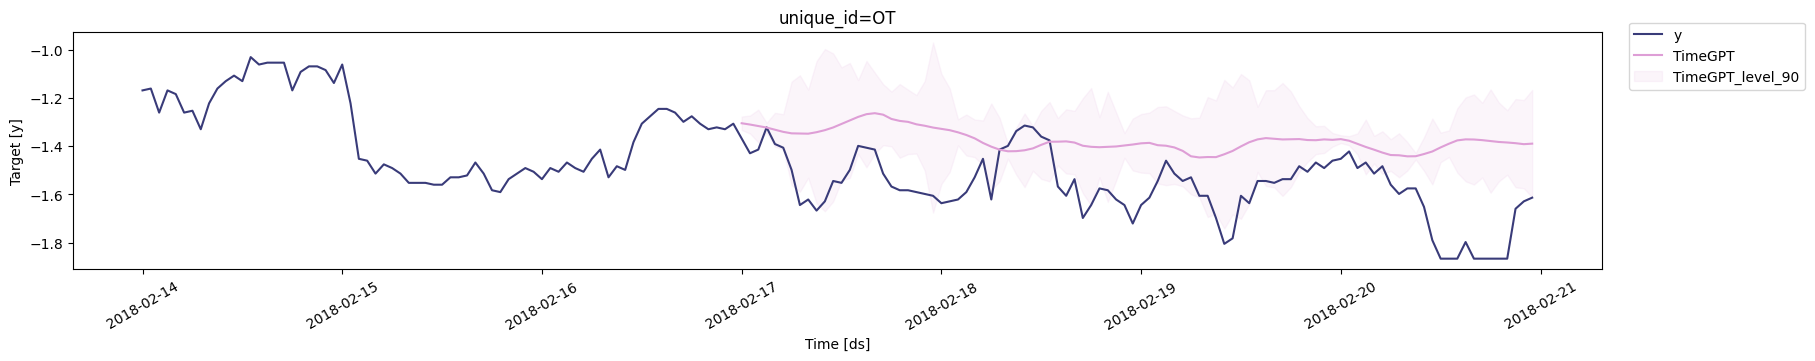

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon

data, *_ = LongHorizon.load(directory='./', group='ETTh1')

# Load environment variables from .env file
load_dotenv()

nixtla_client = NixtlaClient(
    api_key = os.getenv('timegptapikey')
)

# Example usage of the forecast method
# Assuming you have a DataFrame `df` with your time series data
# Replace `df` with your actual DataFrame variable

test = data[-96:]
input_seq = data[-1104:-96] 

fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

nixtla_client.plot(data[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

## Finetuning timegpt with provided data

In [20]:
import pandas as pd
from nixtla import NixtlaClient
from dotenv import load_dotenv
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

# Load environment variables from .env file
load_dotenv()

nixtla_client = NixtlaClient(
    api_key = os.getenv('timegptapikey')
)

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')

timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

nixtla_client.plot(
    df, timegpt_fcst_finetune_df, 
    time_col='timestamp', target_col='value',
)

train = df[:-24]
test = df[-24:]

depths = [1, 2, 3, 4, 5]

test = test.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
    df=train, 
    h=24, 
    finetune_steps=5,
    finetune_depth=depth,
    time_col='timestamp', 
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_depth{depth}'] = preds

test['unique_id'] = 0

evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="value")
evaluation

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
IN

,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,22.675540,17.908963,21.243560,24.745096,29.183245
1,0,mse,677.254283,461.320852,671.131971,991.835359,1147.905234


## Analmoly detection

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0', 'year_2007.0', 'year_2008.0', 'year_2009.0', 'year_2010.0', 'year_2011.0', 'year_2012.0', 'year_2013.0', 'year_2014.0', 'year_2015.0', 'year_2016.0']
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


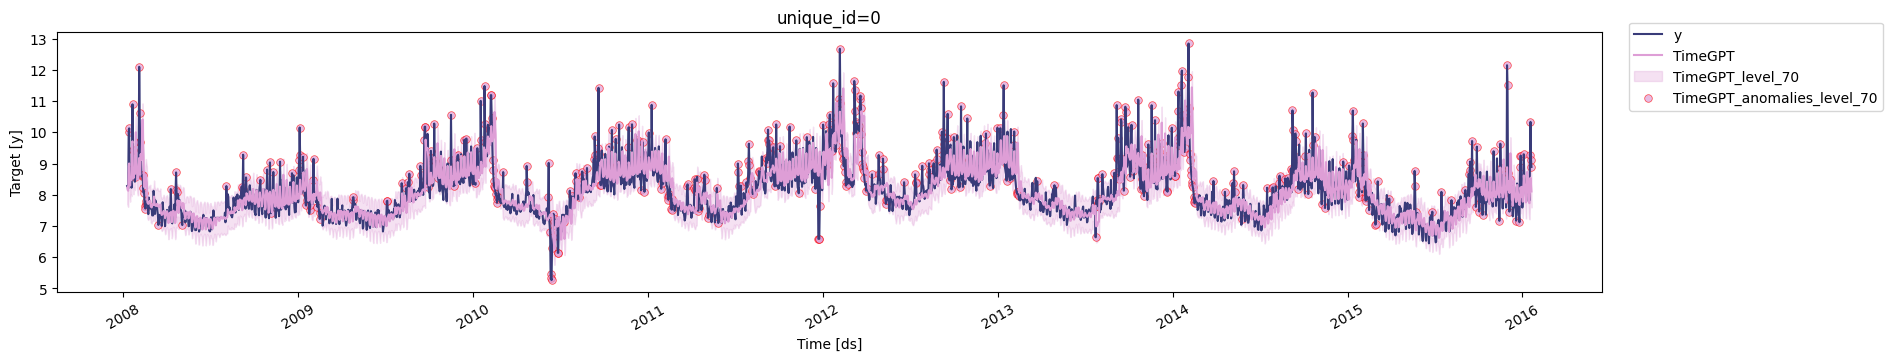

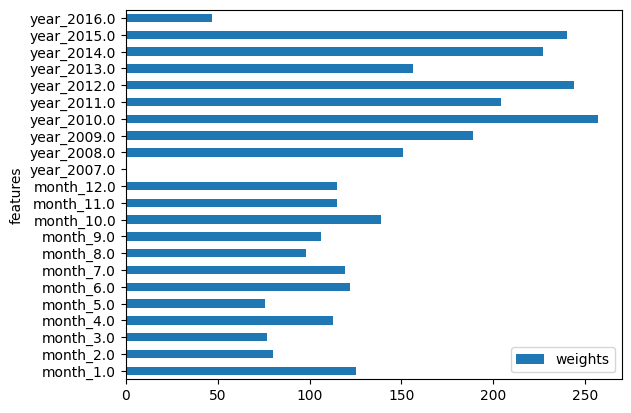

In [21]:
import pandas as pd
from nixtla import NixtlaClient

# Load environment variables from .env file
load_dotenv()

nixtla_client = NixtlaClient(
    api_key = os.getenv('timegptapikey')
)

df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv')

nixtla_client.plot(df, max_insample_length=365)

anomalies_df = nixtla_client.detect_anomalies(df, freq='D')

nixtla_client.plot(df, anomalies_df)

anomalies_df_x = nixtla_client.detect_anomalies(
    df,
    freq='D', 
    date_features=['month', 'year'],
    date_features_to_one_hot=True,
)

nixtla_client.weights_x.plot.barh(x='features', y='weights')

anomalies_df = nixtla_client.detect_anomalies(
    df, 
    freq='D',
    level=70
)

nixtla_client.plot(df, anomalies_df)

## Energy forcasting

C:\Users\Nickk\AppData\Local\Temp\ipykernel_25520\2129833477.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 4.002232074737549


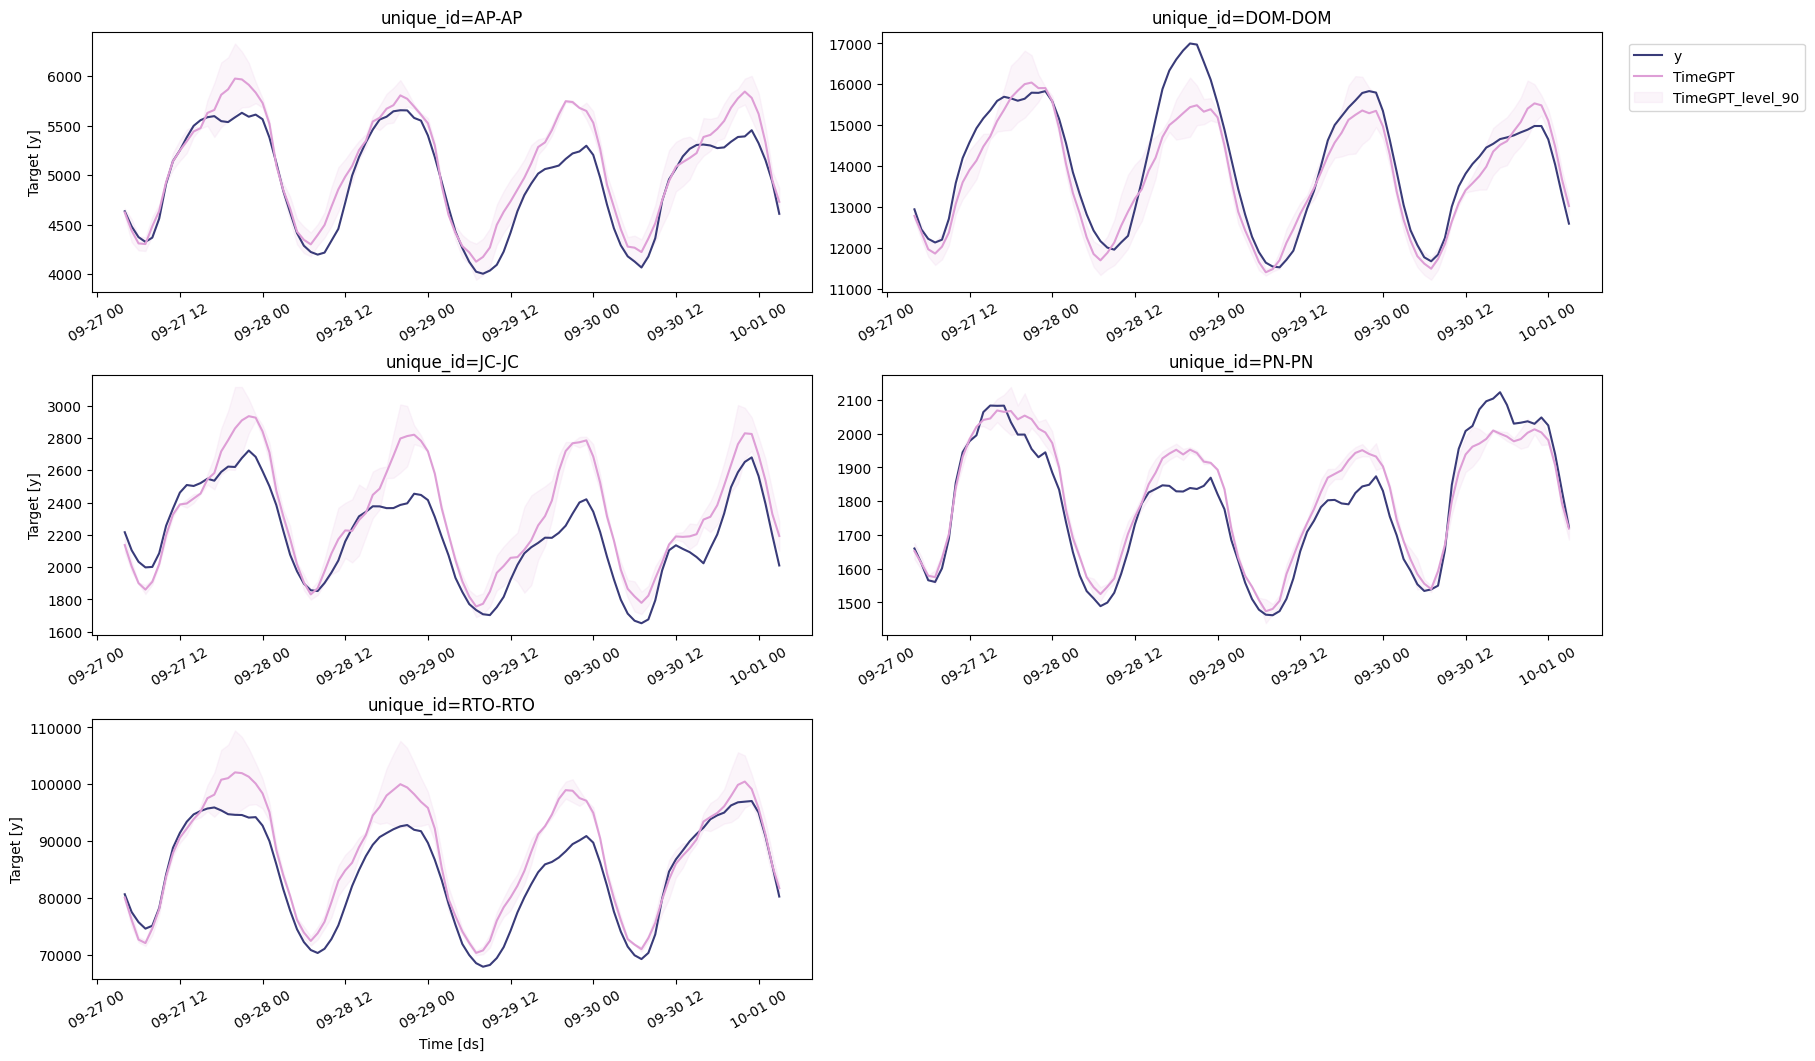

In [22]:
import time

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')

nixtla_client.plot(
    df, 
    max_insample_length=365, 
)

test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 4 days (96 *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)

start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

## BTC value forcasting

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


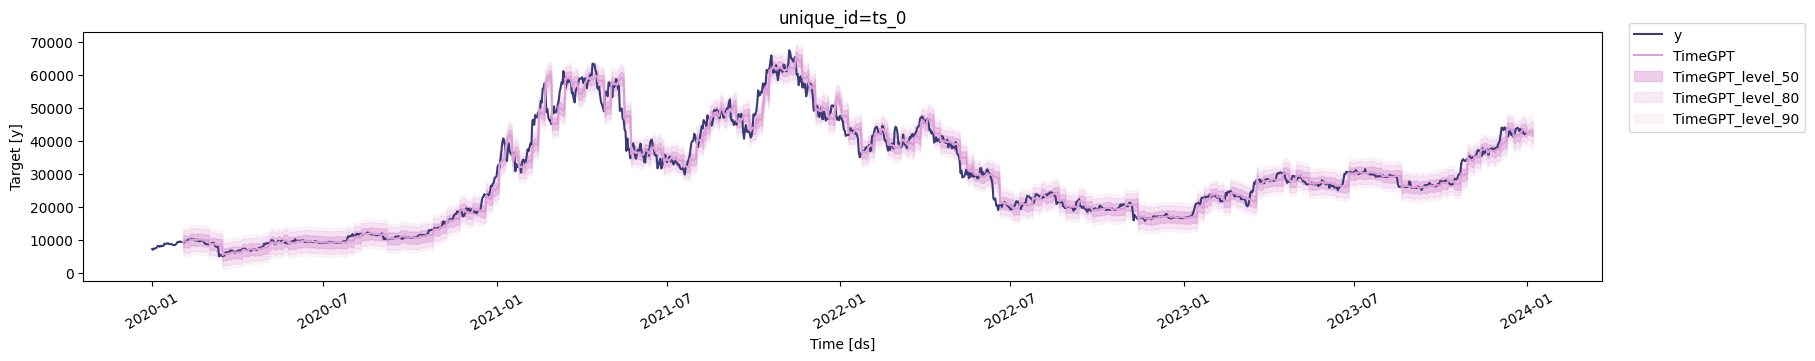

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/bitcoin_price_usd.csv', sep=',')  

df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

nixtla_client.plot(df)

level = [50,80,90] # confidence levels 

fcst = nixtla_client.forecast(df, h=7, level=level)

nixtla_client.plot(df, fcst, level=level)

nixtla_client.plot(df, fcst, level=level, max_insample_length=60)

forecast = nixtla_client.forecast(df, h=7, level=level, add_history=True)

nixtla_client.plot(df, forecast, level=level)